In [1]:
import os, glob
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch
from haloflow import data as D
from haloflow import util as U

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [5]:
qphis0 = U.read_best_ndes('msmh.mags.maf', device=device)
qphis1 = U.read_best_ndes('msmh.mags_morph.maf', device=device)
qphis2 = U.read_best_ndes('msmh.mags_morph_satlum_all.maf', device=device)
qphis3 = U.read_best_ndes('msmh.mags_morph_satlum_all_rich_all.maf', device=device)

391 models trained
[138, 86, 126, 235, 213]
292 models trained
[49, 34, 95, 141, 92]
484 models trained
[328, 410, 99, 247, 97]
100 models trained
[71, 96, 37, 18, 77]


In [6]:
y0, x0 = D.get_subhalos('test', 'mags', snapshot=91)
y1, x1 = D.get_subhalos('test', 'mags_morph', snapshot=91)
y2, x2 = D.get_subhalos('test', 'mags_morph_satlum_all', snapshot=91)
y3, x3 = D.get_subhalos('test', 'mags_morph_satlum_all_rich_all', snapshot=91)

In [ ]:
n_sample = 10000

ranks0, ranks1, ranks2, ranks3 = [], [], [], []
y_nde0, y_nde1, y_nde2, y_nde3 = [], [], [], []

for i in trange(y0.shape[0]): 
    for qphis, ranks, y_nde, xs, ys in zip([qphis0, qphis1, qphis2, qphis3], 
                                           [ranks0, ranks1, ranks2, ranks3], 
                                           [y_nde0, y_nde1, y_nde2, y_nde3], 
                                           [x0, x1, x2, x3], [y0, y1, y2, y3]): 
        y_samp = []
        for qphi in qphis: 
            _samp = qphi.sample((int(n_sample/len(qphis0)),),
                               x=torch.tensor(xs[i], dtype=torch.float32).to(device), 
                               show_progress_bars=False)
            y_samp.append(_samp.detach().cpu().numpy())
        y_nde.append(np.concatenate(np.array(y_samp), axis=0))        
    
        _ranks = []
        for i_dim in range(y_nde[-1].shape[1]): 
            _ranks.append(np.mean(y_nde[-1][:,i_dim].flatten() < ys[i, i_dim]))
        ranks.append(_ranks)
    
ranks0 = np.array(ranks0)
ranks1 = np.array(ranks1)
ranks2 = np.array(ranks2)
ranks3 = np.array(ranks3)

y_nde0 = np.array(y_nde0)
y_nde1 = np.array(y_nde1)
y_nde2 = np.array(y_nde2)
y_nde3 = np.array(y_nde3)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
fig = plt.figure(figsize=(12,3.5))
sub = fig.add_subplot(121)

for ranks in [ranks0, ranks1, ranks2, ranks3]: 
    _ = sub.hist(ranks[:,0], range=(0., 1), bins=20, histtype='step', density=True, linewidth=2)

sub.plot([0., 1.], [1., 1.], c='k', ls='--')
sub.text(0.05, 0.95, r'$\log M_*$', fontsize=20, transform=sub.transAxes, ha='left', va='top')
sub.set_xlabel('rank statistics', fontsize=20)
sub.set_xlim(0., 1.)
sub.set_ylim(0., 3.)
sub.set_yticks([])

sub = fig.add_subplot(122)

for ranks in [ranks0, ranks1, ranks2, ranks3]: 
    _ = sub.hist(ranks[:,1], range=(0., 1), bins=20, histtype='step', density=True, linewidth=2)

sub.plot([], [], c='C0', label=r'mags')
sub.plot([], [], c='C1', label=r'mags+morph')
sub.plot([], [], c='C2', label=r'mags+morph+sat.lum.')
sub.plot([], [], c='C2', label=r'mags+morph+sat.lum.+rich')

sub.legend(loc='upper right', handletextpad=0.2, fontsize=15)
sub.plot([0., 1.], [1., 1.], c='k', ls='--')
sub.text(0.05, 0.95, r'$\log M_h$', fontsize=20, transform=sub.transAxes, ha='left', va='top')
sub.set_xlabel('rank statistics', fontsize=20)
sub.set_xlim(0., 1.)
sub.set_ylim(0., 3.)
sub.set_yticks([])

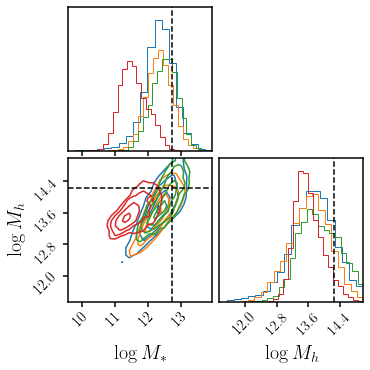

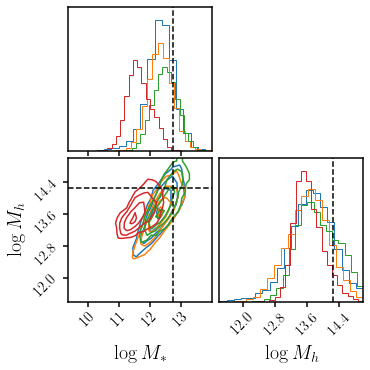

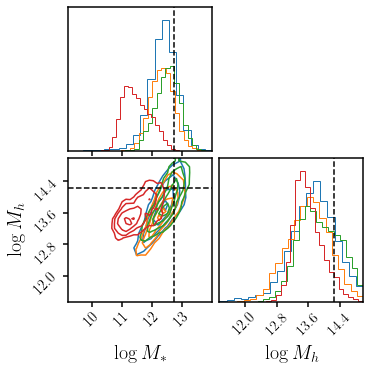

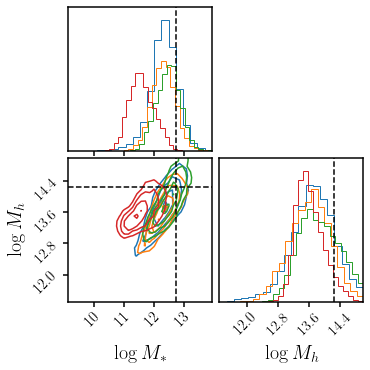

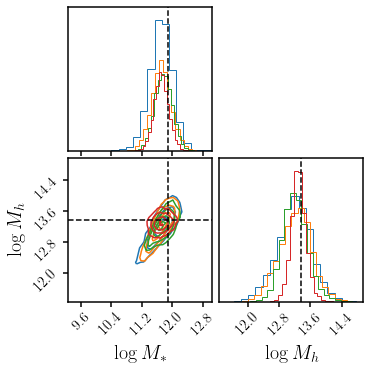

In [23]:
for i in range(5):#y0.shape[0]): 
    fig = DFM.corner(y_nde0[i], color='C0', plot_datapoints=False, plot_density=False)
    _ = DFM.corner(y_nde1[i], color='C1', plot_datapoints=False, plot_density=False, fig=fig)
    _ = DFM.corner(y_nde2[i], color='C2', plot_datapoints=False, plot_density=False, fig=fig)
    _ = DFM.corner(y_nde3[i], 
                   labels=[r'$\log M_*$', r'$\log M_h$'], label_kwargs={'fontsize': 20},
                   color='C3', plot_datapoints=False, plot_density=False, fig=fig)
    DFM.overplot_lines(fig, y0[i], color='k', linestyle='--')
    plt.show()

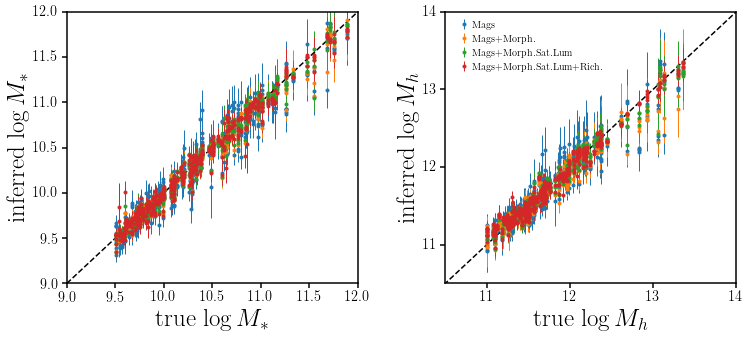

In [11]:
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(121)

for i, ys, y_nde in zip(range(4), [y0, y1, y2, y3], [y_nde0, y_nde1, y_nde2, y_nde3]): 
    q1, q2, q3 = np.quantile(y_nde[:,:,0], (0.16, 0.5, 0.84), axis=1)
    sub.errorbar(ys[:,0], q2, yerr=[q2-q1, q3-q2], fmt='.C%i' % i, lw=1)

sub.plot([9., 15], [9., 15], c='k', ls='--')
sub.set_xlabel(r'true $\log M_*$', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_ylabel(r'inferred $\log M_*$', fontsize=25)
sub.set_ylim(9., 12.)

sub = fig.add_subplot(122)
lbls = ['Mags', 'Mags+Morph.', 'Mags+Morph.Sat.Lum', 'Mags+Morph.Sat.Lum+Rich.']
for i, ys, y_nde, lbl in zip(range(4), [y0, y1, y2, y3], [y_nde0, y_nde1, y_nde2, y_nde3], lbls): 
    q1, q2, q3 = np.quantile(y_nde[:,:,1], (0.16, 0.5, 0.84), axis=1)
    sub.errorbar(ys[:,1], q2, yerr=[q2-q1, q3-q2], fmt='.C%i' % i, lw=1, label=lbl)
sub.legend(loc='upper left', handletextpad=-0.2, fontsize=10)

sub.plot([9., 15], [9., 15], c='k', ls='--')
sub.set_xlabel(r'true $\log M_h$', fontsize=25)
sub.set_xlim(10.5, 14.)
sub.set_xticks([11, 12, 13, 14])
sub.set_ylabel(r'inferred $\log M_h$', fontsize=25)
sub.set_ylim(10.5, 14.)
sub.set_yticks([11, 12, 13, 14])

fig.subplots_adjust(wspace=0.3)

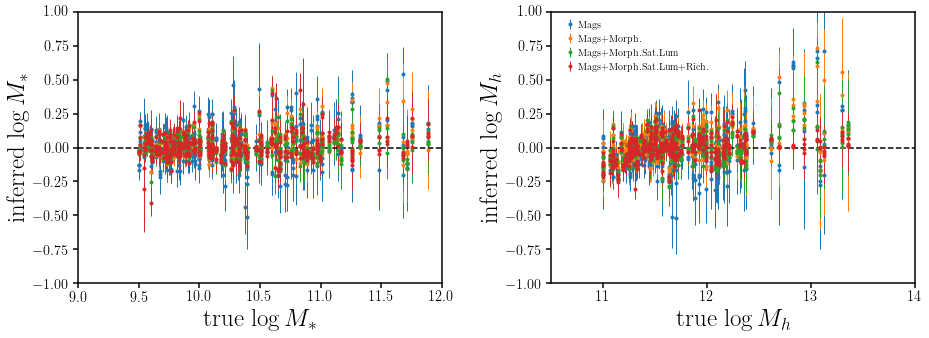

In [15]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(121)

for i, ys, y_nde in zip(range(4), [y0, y1, y2, y3], [y_nde0, y_nde1, y_nde2, y_nde3]): 
    q1, q2, q3 = np.quantile(y_nde[:,:,0], (0.16, 0.5, 0.84), axis=1)
    sub.errorbar(ys[:,0], ys[:,0] - q2, yerr=[q2-q1, q3-q2], fmt='.C%i' % i, lw=1)

sub.plot([9., 15], [0., 0.], c='k', ls='--')
sub.set_xlabel(r'true $\log M_*$', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_ylabel(r'inferred $\log M_*$', fontsize=25)
sub.set_ylim(-1, 1)

sub = fig.add_subplot(122)
lbls = ['Mags', 'Mags+Morph.', 'Mags+Morph.Sat.Lum', 'Mags+Morph.Sat.Lum+Rich.']
for i, ys, y_nde, lbl in zip(range(4), [y0, y1, y2, y3], [y_nde0, y_nde1, y_nde2, y_nde3], lbls): 
    q1, q2, q3 = np.quantile(y_nde[:,:,1], (0.16, 0.5, 0.84), axis=1)
    sub.errorbar(ys[:,1], ys[:,1]-q2, yerr=[q2-q1, q3-q2], fmt='.C%i' % i, lw=1, label=lbl)
sub.legend(loc='upper left', handletextpad=-0.2, fontsize=10)

sub.plot([9., 15], [0., 0.], c='k', ls='--')
sub.set_xlabel(r'true $\log M_h$', fontsize=25)
sub.set_xlim(10.5, 14.)
sub.set_xticks([11, 12, 13, 14])
sub.set_ylabel(r'inferred $\log M_h$', fontsize=25)
sub.set_ylim(-1, 1)

fig.subplots_adjust(wspace=0.3)

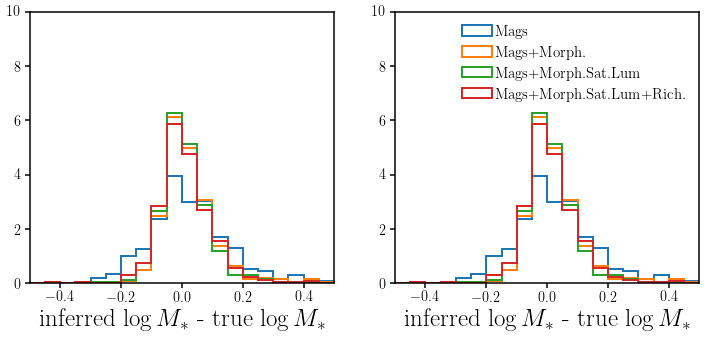

In [10]:
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(121)

for i, ys, y_nde in zip(range(4), [y0, y1, y2, y3], [y_nde0, y_nde1, y_nde2, y_nde3]): 
    q1, q2, q3 = np.quantile(y_nde[:,:,0], (0.16, 0.5, 0.84), axis=1)
    _ = sub.hist(ys[:,0] - q2, range=(-1., 1.), bins=40, histtype='step', density=True, linewidth=2)

sub.set_xlabel(r'inferred $\log M_*$ - true $\log M_*$', fontsize=25)
sub.set_xlim(-0.5, 0.5)
sub.set_ylim(0., 10)

sub = fig.add_subplot(122)
lbls = ['Mags', 'Mags+Morph.', 'Mags+Morph.Sat.Lum', 'Mags+Morph.Sat.Lum+Rich.']

for i, ys, y_nde, lbl in zip(range(4), [y0, y1, y2, y3], [y_nde0, y_nde1, y_nde2, y_nde3], lbls): 
    q1, q2, q3 = np.quantile(y_nde[:,:,0], (0.16, 0.5, 0.84), axis=1)
    _ = sub.hist(ys[:,0] - q2, range=(-1., 1.), bins=40, histtype='step', density=True, linewidth=2, label=lbl)
sub.legend(loc='upper right', handletextpad=0.2, fontsize=15)

sub.set_xlabel(r'inferred $\log M_*$ - true $\log M_*$', fontsize=25)
sub.set_xlim(-0.5, 0.5)
sub.set_ylim(0., 10)

fig.subplots_adjust(wspace=0.2)